This part of the tutorial employs shape data of 116 distal femora that where, among others, used in

[Rigid motion invariant statistical shape modeling based on discrete fundamental forms](https://doi.org/10.1016/j.media.2021.102178), F. Ambellan, S. Zachow, Christoph von Tycowicz, Medical Image Analysis (2021). [PDF](https://arxiv.org/pdf/2111.06850.pdf)

The respective segmentation masks are publicly available at [pubdata.zib.de](https://pubdata.zib.de).

To speed up things a little bit, this part of the tutorial starts right after the model creation step, i.e. we have already constructed a shape model $\left(\mu, \{\vartheta_k\}_1^d \right),$ comprising mean $\mu$
and principal directions $\{\vartheta_k\}_1^d$, s.t.

\begin{equation}
s_i = \text{Exp}_\mu\bigg(\sum_{k=1}^{n-1} \underbrace{g_\mu(\text{Log}_\mu(s_i), \vartheta_k)}_{\alpha_{i}^k}\vartheta_k\bigg),
\end{equation}

holds for all input shapes $s_i$. In the following we want to visualize the principal weights $\{\alpha_i^k\}$ in different ways and use them to perform a classification experiment on osteoarthritis.

# Visualization of Principal Weights $\{\alpha_i^k\}$

## Load data

In [4]:
import numpy as np
from tutorial2_pop_med_image_shape_ana.utils.sammon import sammon
from tutorial2_pop_med_image_shape_ana.utils.utils import runClassification
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

dataFCM = np.load('tutorial2_pop_med_image_shape_ana/data/femurOAclassificationDataFCM.npy')
dataPDM = np.load('tutorial2_pop_med_image_shape_ana/data/femurOAclassificationDataPDM.npy')

# first row -> label {0, 1}, second to last row -> shape weights (column is sample, row is feature)
labels = dataFCM[0, :]
fcmFeatures = dataFCM[1:, :]
pdmFeatures = dataPDM[1:, :]

# dark green (FCM) and dark violet (PDM)
colors = ['#008c04', '#ae00d8']

## Visualization of Two Principal Weights

Choose different values for 'pw1' and 'pw2'. What is your impression?
- Are there some weights more expressive than others?
- What can you say about the difference between FCM and PDM?

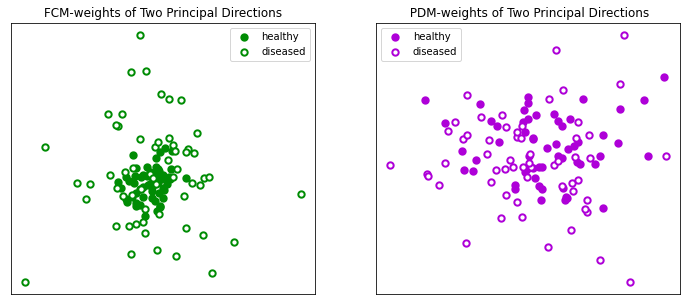

In [5]:
[pW1, pW2] = [10, 15]

# split data into healthy and diseased index lists
healthy = np.where(labels == 0)[0]
diseased = np.where(labels != 0)[0]

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
data_list = [fcmFeatures, pdmFeatures]
title_list = ['FCM-weights of Two Principal Directions', ' PDM-weights of Two Principal Directions']
legendLocation_list = ['upper right', 'upper left']

for k in range(2):
    ax[k].scatter(data_list[k][pW1, healthy], data_list[k][pW2, healthy], s=40, linewidths=2, c=colors[k], label='healthy')
    ax[k].scatter(data_list[k][pW1, diseased], data_list[k][pW2, diseased], s=40, linewidths=2, c='white', edgecolors=colors[k], label='diseased')
    ax[k].set_xticks([])
    ax[k].set_yticks([])
    ax[k].set_title(title_list[k])
    ax[k].legend(loc=legendLocation_list[k])

plt.show()

## Sammon Projection to Two Dimensions

the Sammon projection tries to find a low dimensional (2d in our case) representation of some given high dimensional data, s.t. the following error is minimal

\begin{equation}
Err = \dfrac{1}{\sum_{i<j}d_{R^2}(\text{pr}(\alpha_i), \text{pr}(\alpha_i))} \sum_{i<j}\dfrac{(d_{R^2}(\text{pr}(\alpha_i), \text{pr}(\alpha_i)) - d_{R^d}(\alpha_i, \alpha_j))^2}{d_{R^2}(\text{pr}(\alpha_i), \text{pr}(\alpha_i))}.
\end{equation}

In other words: The distances between two weight vectors $\alpha_i, \alpha_j$ before projection should be close to those after projection.

([A nonlinear mapping for data structure analysis](https://doi.org/10.1109/T-C.1969.222678), JW. Sammon, IEEE Transactions on computers (1969). [PDF](http://syllabus.cs.manchester.ac.uk/pgt/2021/COMP61021/reference/Sammon.pdf))

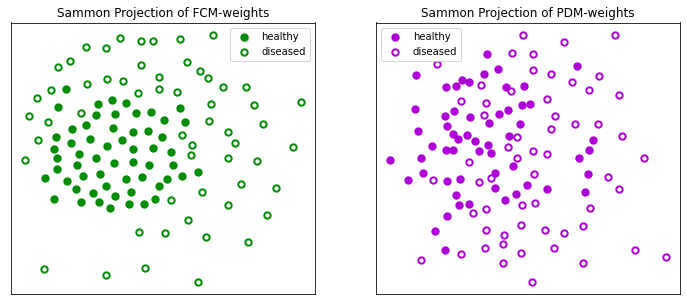

In [6]:
fcmSammon, _ = sammon(fcmFeatures.transpose(), 2, display=0)
pdmSammon, _ = sammon(pdmFeatures.transpose(), 2, display=0)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
data_list = [fcmSammon, pdmSammon]
title_list = ['Sammon Projection of FCM-weights', 'Sammon Projection of PDM-weights']

for k in range(2):
    ax[k].scatter(data_list[k][healthy, 0], data_list[k][healthy, 1], s=40, linewidths=2, c=colors[k], label='healthy')
    ax[k].scatter(data_list[k][diseased, 0], data_list[k][diseased, 1], s=40, linewidths=2, c='white', edgecolors=colors[k], label='diseased')
    ax[k].set_xticks([])
    ax[k].set_yticks([])
    ax[k].set_title(title_list[k])
    ax[k].legend(loc=legendLocation_list[k])

plt.show()

# Osteoarthritis Classification Experiment

Part  1  (9)
Part  2  (9)
Part  3  (9)
Part  4  (9)
Part  5  (9)
Part  6  (9)
Part  7  (9)
Part  8  (9)
Part  9  (9)
Part  1  (9)
Part  2  (9)
Part  3  (9)
Part  4  (9)
Part  5  (9)
Part  6  (9)
Part  7  (9)
Part  8  (9)
Part  9  (9)


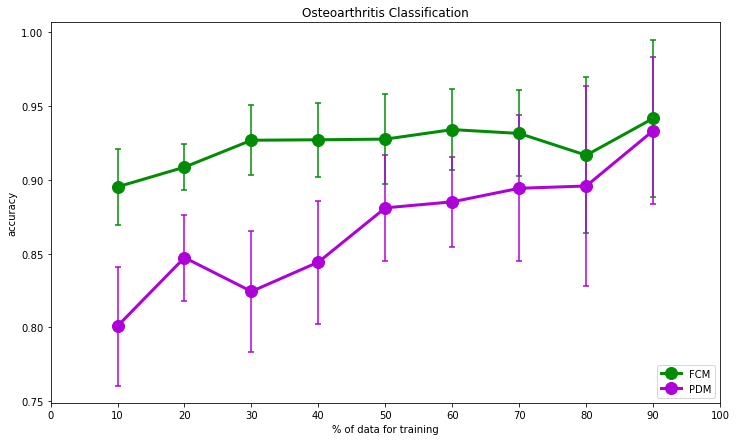

In [20]:
nPartition = 9
nRandomSamplings = 10

# normalize each feature vector separately
fcmFeatures = normalize(fcmFeatures, axis=0, norm="l2")
pdmFeatures = normalize(pdmFeatures, axis=0, norm="l2")

fcmavgAccuracyPerPartition, fcmstdDevPerPartition = runClassification(nPartition, nRandomSamplings, fcmFeatures, labels)
pdmavgAccuracyPerPartition, pdmstdDevPerPartition = runClassification(nPartition, nRandomSamplings, pdmFeatures, labels)

data_list_avg = [fcmavgAccuracyPerPartition, pdmavgAccuracyPerPartition]
data_list_std_high = [fcmavgAccuracyPerPartition + fcmstdDevPerPartition, pdmavgAccuracyPerPartition + pdmstdDevPerPartition]
# cut off at 1.0
data_list_std_high[0][data_list_std_high[0]>1.0] = 1.0
data_list_std_high[1][data_list_std_high[1] > 1.0] = 1.0
data_list_std_low = [fcmavgAccuracyPerPartition - fcmstdDevPerPartition, pdmavgAccuracyPerPartition - pdmstdDevPerPartition]

label_list = ['FCM', 'PDM']

x = [100 * lp/(nPartition+1) for lp in range(1, nPartition + 1)]
plt.figure(figsize=(12,7))
for k in range(2):
    plt.plot(x, data_list_avg[k], linestyle='-', marker='o', color=colors[k], label=label_list[k], lw=3, ms=12)
    # some kind of whisker bars showing the standard deviation around the average
    plt.vlines(x=x, ymin=data_list_std_low[k], ymax=data_list_std_high[k], colors=colors[k], lw=1.5)
    plt.scatter(x, data_list_std_low[k], marker='_', color=colors[k], lw=1.5)
    plt.scatter(x, data_list_std_high[k], marker='_', color=colors[k], lw=1.5)

plt.title('Osteoarthritis Classification')
plt.legend(loc='lower right')
plt.xlabel('% of data for training')
plt.ylabel('accuracy')
plt.xticks(range(0, 101, 10))


plt.show()
